# exploring clip and vgg similarity scores


In [11]:
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import cosine
import numpy as np
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from scipy.spatial.distance import cosine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
csvs_path = Path('csvs')

In [13]:
df = pd.read_csv(csvs_path / 'improving_descriptions_step_by_step_with_clip_lpips.csv')

In [14]:
df

,uid,participant_age,participant_gender,participant_native,gt,session,attempt,prompt,gen,similarity,cosine_distance,subjective_score,ts,clip_cosine_distance,clip_scaled_similarity,lpips_distance,vgg_last_conv_distance,vgg_last_conv_similarity,real_token_num
0,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,bedroom_l.jpg,1,1,car,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,54,0.9103,NaN,1754329040,0.483178,75,0.784130,0.925571,53,1
1,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,bedroom_l.jpg,1,2,a bedroom,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,77,0.4480,1.0,1754329087,0.183378,90,0.756417,0.763904,61,2
2,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,bedroom_l.jpg,1,3,a wooden bedroom with yellow pillows and a tre...,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,78,0.4308,3.0,1754329175,0.210310,89,0.741583,0.739908,63,13
3,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,bedroom_l.jpg,1,4,a bedroom from the seventees with a tree in th...,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,78,0.4393,3.0,1754329318,0.231009,88,0.754603,0.781266,60,51
4,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,bedroom_l.jpg,1,5,a bedroom from the seventees with a big tree i...,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,72,0.5407,4.0,1754329452,0.235207,88,0.740701,0.791758,60,61
5,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,garden_h.jpg,2,1,grandma,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,61,0.7791,2.0,1754329530,0.611065,69,0.787015,0.901690,54,1
6,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,garden_h.jpg,2,2,a garden,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,70,0.5834,1.0,1754329570,0.301960,84,0.718572,0.815372,59,2
7,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,garden_h.jpg,2,3,a winter european garden,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,73,0.5270,2.0,1754329613,0.290789,85,0.732328,0.799971,60,4
8,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,garden_h.jpg,2,4,"a winter european garden, brick building in th...",logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,76,0.4799,4.0,1754329681,0.257071,87,0.722018,0.785195,60,25
9,05bf6f93d211455ebbf60d18e99e7ad3,100,Prefer not to say,Yes,garden_h.jpg,2,5,A formal garden enclosed by brick walls featur...,logs\gen_images\05bf6f93d211455ebbf60d18e99e7a...,81,0.3725,1.0,1754329811,0.204460,89,0.710268,0.690132,65,107


In [15]:
pd.set_option('display.max_colwidth', None)
df[['gt', 'prompt', 'similarity', 'vgg_last_conv_similarity', 'clip_scaled_similarity', 'lpips_distance', 'real_token_num']]

,gt,prompt,similarity,vgg_last_conv_similarity,clip_scaled_similarity,lpips_distance,real_token_num
0,bedroom_l.jpg,car,54,53,75,0.784130,1
1,bedroom_l.jpg,a bedroom,77,61,90,0.756417,2
2,bedroom_l.jpg,a wooden bedroom with yellow pillows and a tree in the background.,78,63,89,0.741583,13
3,bedroom_l.jpg,"a bedroom from the seventees with a tree in the backgournd. all from dark broown wood, with 2 images behind bed and yellow pillows and white blanket. bed head is facing far left angle. looks like it's from the seventees.",78,60,88,0.754603,51
4,bedroom_l.jpg,"a bedroom from the seventees with a big tree in the backgournd (a real tree). All from dark broown wood, with 2 images behind bed and yellow pillows and white blanket, and aplace to put books in front of bed. in the close right corner there's half of a cupboard",72,60,88,0.740701,61
5,garden_h.jpg,grandma,61,54,69,0.787015,1
6,garden_h.jpg,a garden,70,59,84,0.718572,2
7,garden_h.jpg,a winter european garden,73,60,85,0.732328,4
8,garden_h.jpg,"a winter european garden, brick building in the background, and a spiral tree in the center. between plants there's a pavement",76,60,87,0.722018,25
9,garden_h.jpg,"A formal garden enclosed by brick walls features symmetrical, curved flowerbeds filled with red tulips and bordered by low ivy hedges. White gravel paths wind neatly between the beds, converging at the center where a tall, spiral-shaped topiary stands. The background includes a red-brick building with large white-trimmed windows, and several wooden benches are placed along the edges for seating. Neatly trimmed bushes and a few sparse trees add vertical structure, creating a peaceful and orderly atmosphere typical of an English courtyard garden.",81,65,89,0.710268,107


In [13]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_text_embedding(text: str, clip_tokenizer=clip_tokenizer, clip_model=clip_model) -> torch.Tensor:
    real_token_num = len(clip_tokenizer.tokenize(text))
    tokens = clip_tokenizer(text, truncation=True, max_length=77, padding="max_length", return_tensors="pt").to(device)
    with torch.no_grad():
        features = clip_model.get_text_features(**tokens)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features[0]


In [24]:
sessions = df['session'].unique()
session_matrices = {}  # store similarity matrices for each session

for session in sessions:
    prompts = df[df['session'] == session]['prompt'].tolist()
    embeddings = [get_clip_text_embedding(p).cpu().numpy() for p in prompts]
    n = len(embeddings)
    sim_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            cosine_dist = cosine(embeddings[i], embeddings[j])
            scaled_sim = int(((1 - cosine_dist + 1)/2) * 100)  # map to [0, 100]
            sim_matrix[i, j] = scaled_sim
    
    session_matrices[session] = sim_matrix

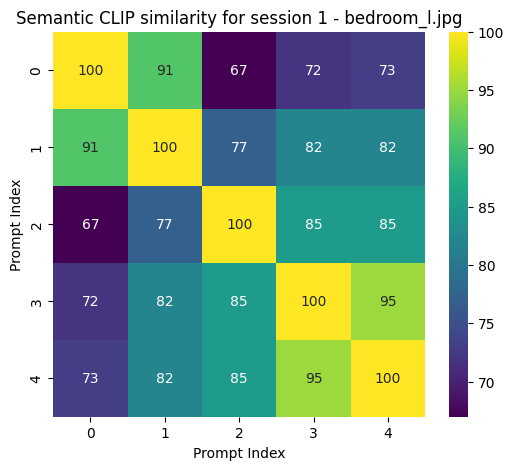

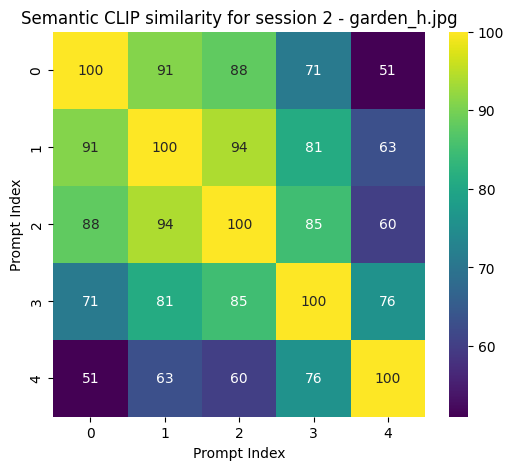

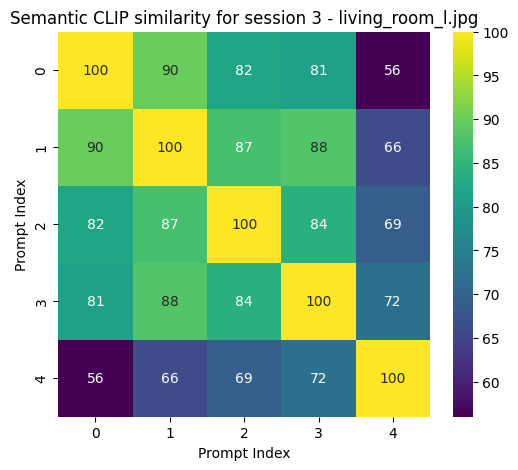

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

for session, sim_matrix in session_matrices.items():
    gt_name = df.loc[df['session'] == session, 'gt'].iloc[0]
    plt.figure(figsize=(6, 5))
    sns.heatmap(sim_matrix, annot=True, fmt=".0f", cmap="viridis")
    plt.title(f"Semantic CLIP similarity for session {session} - {gt_name}")
    plt.xlabel("Prompt Index")
    plt.ylabel("Prompt Index")
    plt.show()

In [52]:
df['gen'][0]



'logs\\gen_images\\05bf6f93d211455ebbf60d18e99e7ad3_session1_iter1.png'

❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session1_iter1.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session1_iter2.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session1_iter3.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session1_iter4.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imag

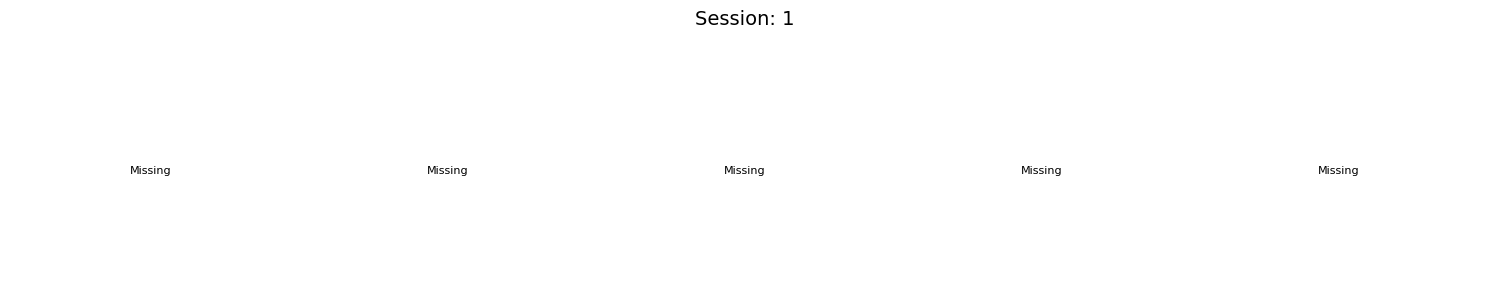

❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session2_iter1.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session2_iter2.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session2_iter3.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session2_iter4.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imag

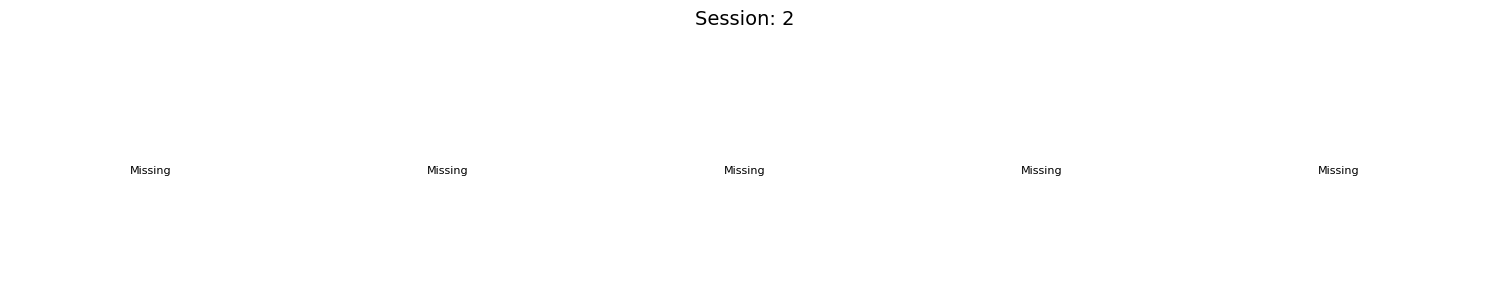

❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session3_iter1.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session3_iter2.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session3_iter3.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imagination_in_translation\data_analysis\logs\gen_images\05bf6f93d211455ebbf60d18e99e7ad3_session3_iter4.png
❌ Missing file: c:\Users\AnatKG\Documents\Neuro Science Masters\year A\python for neuroscientists\final_project\Imag

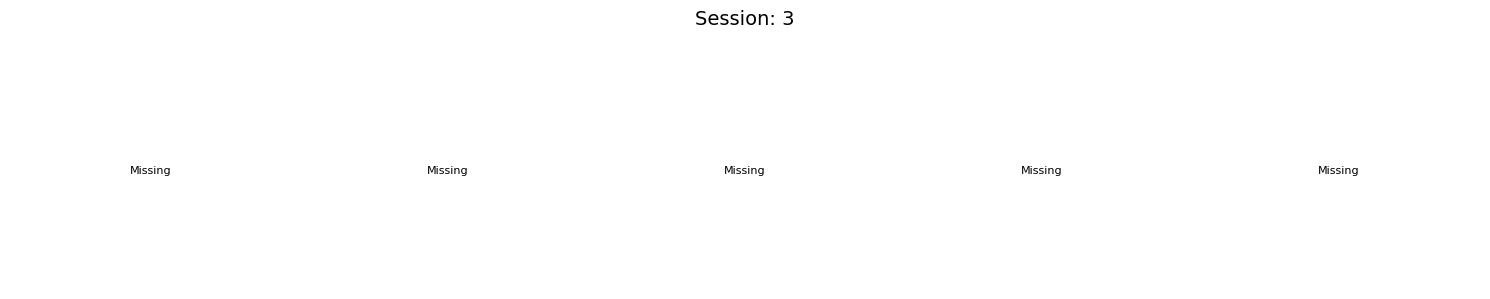

In [56]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure absolute paths
from pathlib import Path
import os

# set this to where your Imagination_in_translation folder is
project_root = Path("C:/Users/AnatKG/Documents/Neuro Science Masters/year A/python for neuroscientists/final_project/Imagination_in_translation")

df['gen'] = df['gen'].apply(lambda p: str(project_root / Path(p)))
grouped = df.groupby("session")

for session, group in grouped:
    fig, axes = plt.subplots(1, len(group), figsize=(3*len(group), 3))
    fig.suptitle(f"Session: {session}", fontsize=14)

    if len(group) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, group.iterrows()):
        img_path = Path(row['gen'])
        if img_path.exists():
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(img_path.name, fontsize=8)
        else:
            print(f"❌ Missing file: {img_path}")
            ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
